In [4]:
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [111]:
num_class = 12
close_num = 12
batch_size = 64
learning_rate = 0.001
num_epochs = 100
sequence_len = 1000 * 5 # sampling_rate * second
overlap = int(sequence_len * 0.3)
alpha = 0.3

In [112]:
data_list = []
scaler = MinMaxScaler((0, 1))

for i in range(1, num_class + 1):
    file_path_fil = "./data/BPF/filterd%02d.csv" % i
    file_path_unfil = "./data/BPF/unfilterd%02d.csv" % i
    data_fil = pd.read_csv(file_path_fil)
    data_np_fil = data_fil.to_numpy().flatten()
    data_np_fil = data_np_fil[:899999] # データ数を揃える
    # df_fil = pd.DataFrame(data_fil)
    # data_unfil = pd.read_csv(file_path_unfil)
    # df_unfil = pd.DataFrame(data_unfil)

    end = len(data_np_fil)
    n = 0
    n_stop = sequence_len
    data_segs = []
    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = data_np_fil[n_start:n_stop].copy()
        data_segs.append([seg])
        n += 1

    data_list.append(data_segs)

In [34]:
data_list[4][0]

[array([0.37779185, 0.37960583, 0.38139324, ..., 0.00149465, 0.00150279,
        0.00151537])]

In [113]:
labels = []
for i in range(len(data_list)):
    for j in range(len(data_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1)

In [114]:
data_df_list = pd.DataFrame(data_list)
tmp = data_df_list.to_numpy().flatten().copy()
data_series_list = pd.Series(tmp).dropna()
data_np_list = data_series_list.to_numpy().flatten() # tmp => data_np_list
labels_np = np.array(labels)
for i in reversed(range(len(data_np_list))):
    if len(data_np_list[i][0]) != sequence_len: # 決まった長さでないといけない
        data_np_list = np.delete(data_np_list, i)
        labels_np = np.delete(labels_np, i)
data_series_list = pd.Series(data_np_list)
labels_series = pd.Series(labels_np)
data_tensor_list = torch.tensor(data_series_list)
labels_tensor = torch.tensor(labels_series)
data_tensor_list.shape, labels_tensor.shape

(torch.Size([3072, 1, 5000]), torch.Size([3072]))

In [115]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 
        self.fc_tsne = nn.Linear(nf * 4, 2)
        self.two_vecs_train = [] # list is faster in appending
        self.two_vecs_test = []

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        two_dimensional_vec = self.fc_tsne(x)
        if self.training:
            self.two_vecs_train.append(two_dimensional_vec.tolist()) # あとでネストしたものをまとめてtensorかndarrayに変換するため
        else:
            self.two_vecs_test.append(two_dimensional_vec.tolist())
        x = self.fc(x)
        return x

In [116]:
class HCU_Dataset(Dataset):
    def __init__(self, dataset, labels) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()        
        return self.radar_heartbeat[idx], self.labels[idx]

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = HCU_Dataset(data_tensor_list, labels_tensor)

データセットでラベルが変わる区切りを発見する(openset用)

In [69]:
dataset[1000]

(tensor([[0.0105, 0.0106, 0.0106,  ..., 0.0023, 0.0022, 0.0022]],
        dtype=torch.float64),
 tensor(2))

### close setの場合

In [117]:
close_train_size = int(0.80 * len(dataset))
close_test_size = len(dataset) - close_train_size
close_train_set, close_test_set = torch.utils.data.random_split(dataset, [close_train_size, close_test_size])
print(f"Train Set: {len(close_train_set)}, Test Set: {len(close_test_set)}")
train_loader = DataLoader(dataset=close_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=close_test_set, batch_size=batch_size, shuffle=False)

Train Set: 2457, Test Set: 615


In [118]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha):
    # alpha: hyper parameter
    output_only_truth = []
    for idx, x in enumerate(output):
        x = x[labels[idx]]
        x = torch.tensor(x).to(device)
        output_only_truth.append([x])
    output_only_truth = torch.tensor(output_only_truth)
    output_only_truth = output_only_truth.float()
    output_only_truth = output_only_truth.to(device)
    # print(output.is_cuda, output_only_truth.is_cuda, label.is_cuda)

    return softmax_loss(output, label) + alpha * center_loss(output, label)
    # return softmax_loss(output, label) + alpha * center_loss(output, label) + cos_loss(output, label)
    # return cos_loss(output_only_truth, label)

In [119]:
model = InceptionTime(1, close_num + 1)
model = model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (signals, labels) in enumerate(train_loader):
        signals = signals.float()
        signals = signals.to(device)
        labels = labels.to(device)
        outputs = model(signals)
        outputs = outputs.to(device)
        loss = triple_joint_loss(outputs, labels, alpha)
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optimizer.step()
        optimizer_centloss.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_18531/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/home/riku/workspace/InceptionTime/env/lib/python3.8/site-packages/torch/overrides.py:1534: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


Epoch [1/`100], Step [10/39], Loss: 5.6670
Epoch [1/`100], Step [20/39], Loss: 5.2962
Epoch [1/`100], Step [30/39], Loss: 5.0744
Epoch [2/`100], Step [10/39], Loss: 4.5235
Epoch [2/`100], Step [20/39], Loss: 4.4983
Epoch [2/`100], Step [30/39], Loss: 4.2181
Epoch [3/`100], Step [10/39], Loss: 4.0793
Epoch [3/`100], Step [20/39], Loss: 4.0392
Epoch [3/`100], Step [30/39], Loss: 3.9134
Epoch [4/`100], Step [10/39], Loss: 3.7641
Epoch [4/`100], Step [20/39], Loss: 3.6598
Epoch [4/`100], Step [30/39], Loss: 3.7266
Epoch [5/`100], Step [10/39], Loss: 3.7170
Epoch [5/`100], Step [20/39], Loss: 3.6638
Epoch [5/`100], Step [30/39], Loss: 3.6229
Epoch [6/`100], Step [10/39], Loss: 3.6181
Epoch [6/`100], Step [20/39], Loss: 3.5279
Epoch [6/`100], Step [30/39], Loss: 3.4546
Epoch [7/`100], Step [10/39], Loss: 3.5229
Epoch [7/`100], Step [20/39], Loss: 3.4827
Epoch [7/`100], Step [30/39], Loss: 3.4165
Epoch [8/`100], Step [10/39], Loss: 3.5491
Epoch [8/`100], Step [20/39], Loss: 3.4391
Epoch [8/`1

In [120]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)
    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    """
    Opensetのためのthreshold-softmax
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    """
    print(_, predicted, one_hot_labels)
    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

TensorBase([0.1487, 0.1153, 0.1045, 0.4707, 0.1374, 0.1106, 0.1523, 0.1028,
            0.3278, 0.3084, 0.1605, 0.2122, 0.1331, 0.1359, 0.1005, 0.1730,
            0.4879, 0.1982, 0.1467, 0.1092, 0.1027, 0.1867, 0.1191, 0.0950,
            0.1188, 0.1587, 0.3306, 0.1633, 0.1102, 0.2687, 0.0974, 0.1075,
            0.1284, 0.0986, 0.1178, 0.6038, 0.1256, 0.1170, 0.1173, 0.1414,
            0.1914, 0.1149, 0.1026, 0.1124, 0.1244, 0.0984, 0.1193, 0.2208,
            0.1173, 0.1038, 0.1323, 0.1152, 0.1597, 0.1541, 0.1061, 0.1283,
            0.1417, 0.1028, 0.1049, 0.1249, 0.1040, 0.1151, 0.1073, 0.1222],
           device='cuda:0') TensorBase([ 0, 11, 10,  9, 11, 11,  2,  4,  9,  9, 11,  4,  2,  5,  6,  0,  4,
             0, 11,  4,  5,  0, 11, 11, 11,  2,  4,  4,  8,  0,  7,  5,  5, 11,
             1,  4,  5,  5, 10,  0,  2,  5,  5,  9,  5,  6,  8,  4, 10,  8,  8,
             4,  5,  0,  5,  8,  5,  5,  5,  4,  5,  8,  5,  8],
           device='cuda:0') tensor([ 0, 11,  6,  9,  5, 11

Text(77.92222222222227, 0.5, 'Ground Truth')

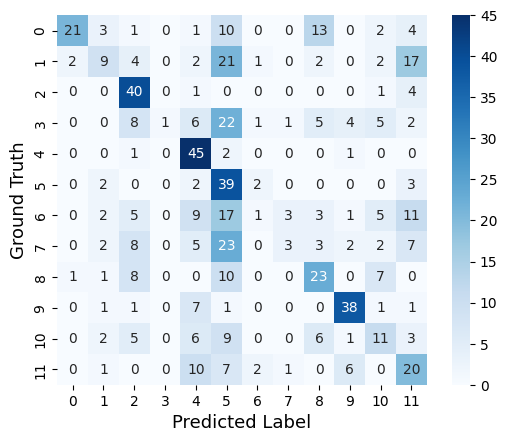

In [121]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
# fig_name = "sklearn_confusion_matrix_{}_{}.png".format(Unknown_label, threshold)